In [24]:
import collections

try:
    collectionsAbc = collections.abc
except AttributeError:
    collectionsAbc = collections

# Compute EOF with `eofs` package
https://ajdawson.github.io/eofs/latest/


In [1]:
import xarray as xr
import numpy as np

import pop_tools
from eofs.xarray import Eof

import matplotlib.pyplot as plt
import matplotlib as mpl

# for cartopy environment
import cartopy
import cmocean.cm as cmo

In [2]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/bsf/'
bsf_filename = 'bsf_1301.017.nc'

In [3]:
### import data
ds = xr.open_dataset(path+bsf_filename)

grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlanticOcean': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [35.0, 80.0], 'TLONG': [260.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 66.0], 'TLONG': [260.0, 340.0]}}
    ],
}

mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='SubpolarRegion')
ds_bsf = ds.where(mask3d.sum('region'))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Perform EOF

In [4]:
# create weights -> grid cell area
weights = ds_bsf.TAREA

# create an EOF solver to do the EOF analysis, and apply the weights
solver = Eof(ds_bsf.BSF, weights=weights)

# create principal component time series (unscaled PCs).
pcs = solver.pcs(npcs=4, pcscaling=0)

# create correlation maps of first 4 EOFs.
eof_corr = solver.eofsAsCorrelation(neofs=4)

# get fraction of the total variance explained by each EOF mode
variance_fractions = solver.varianceFraction()

### Plot Principal component (PC) time series

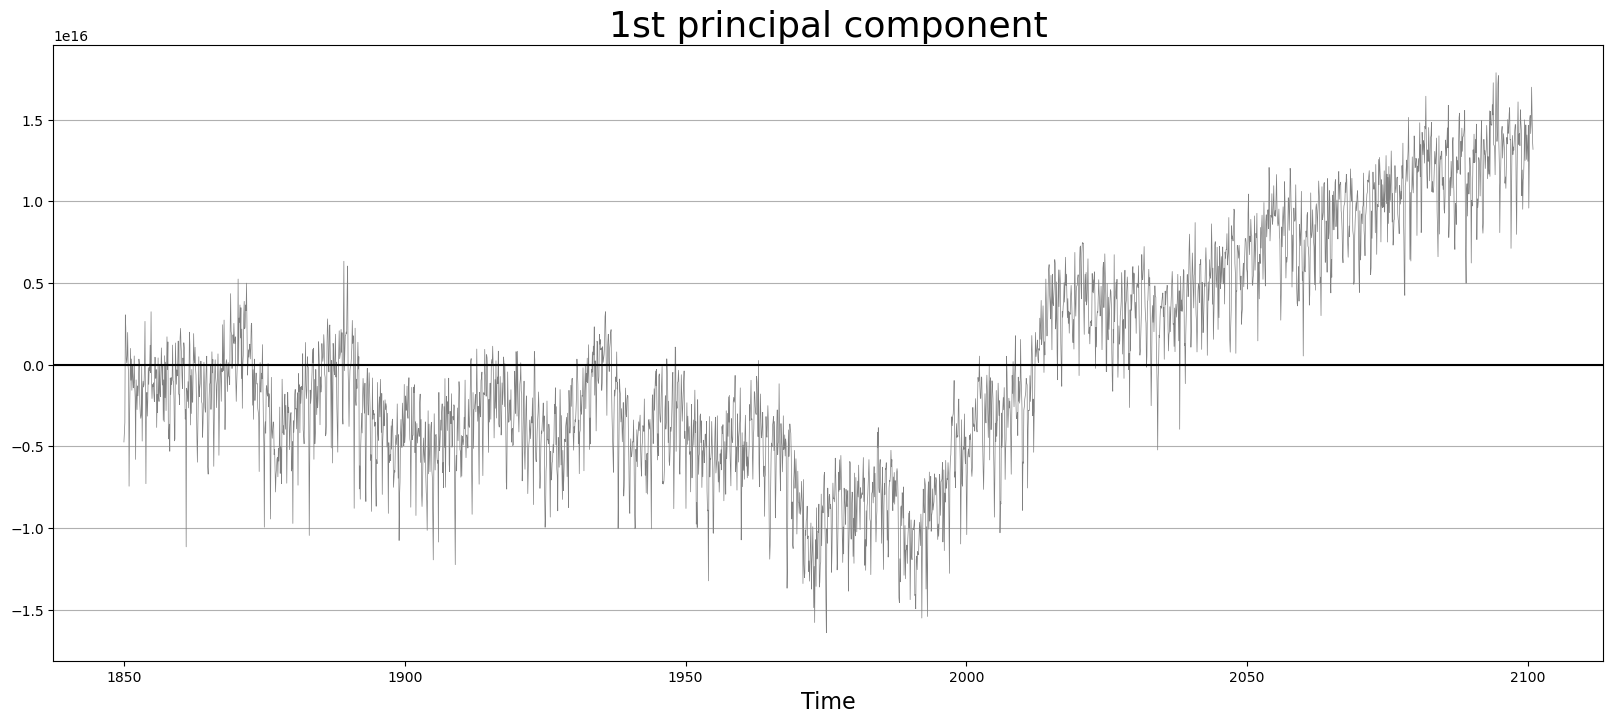

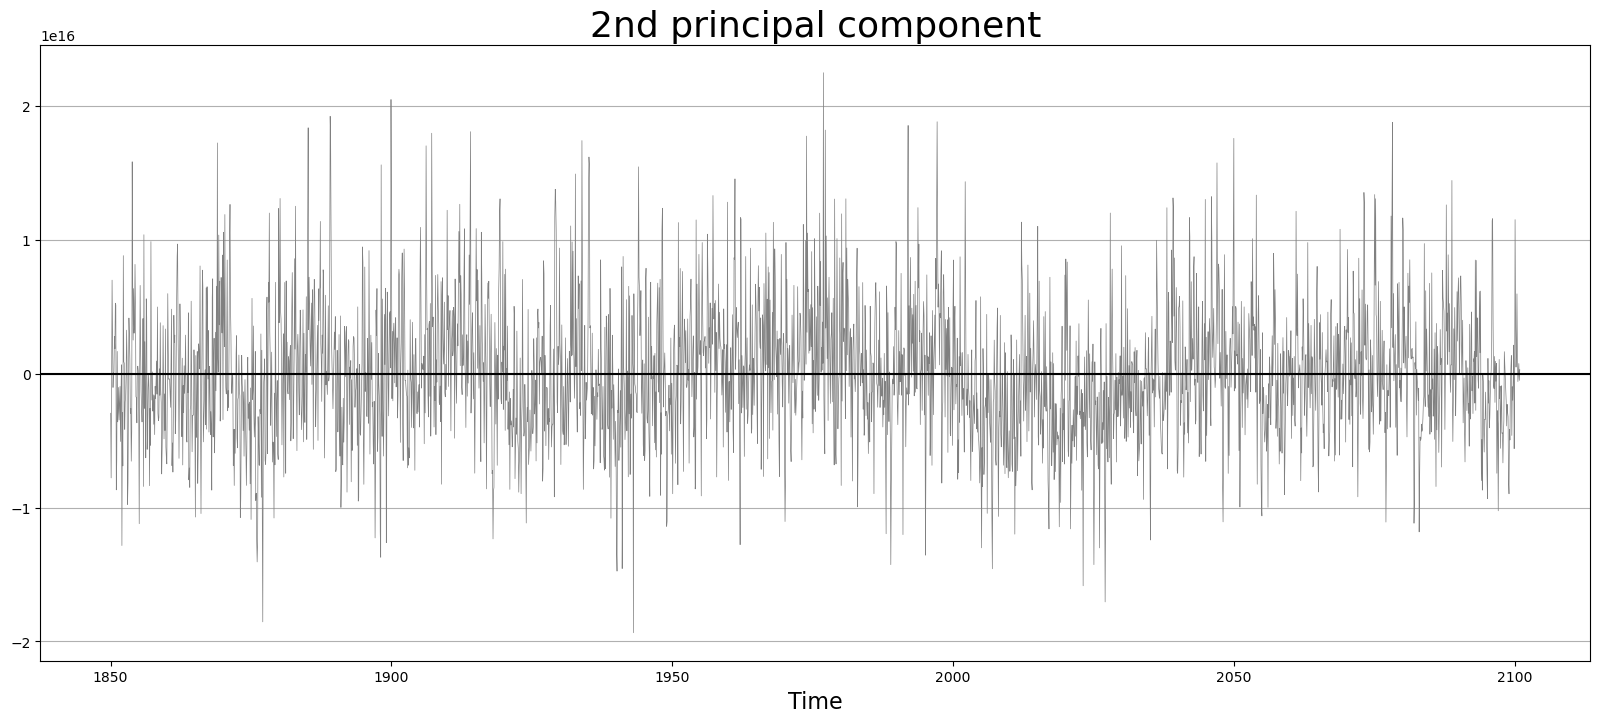

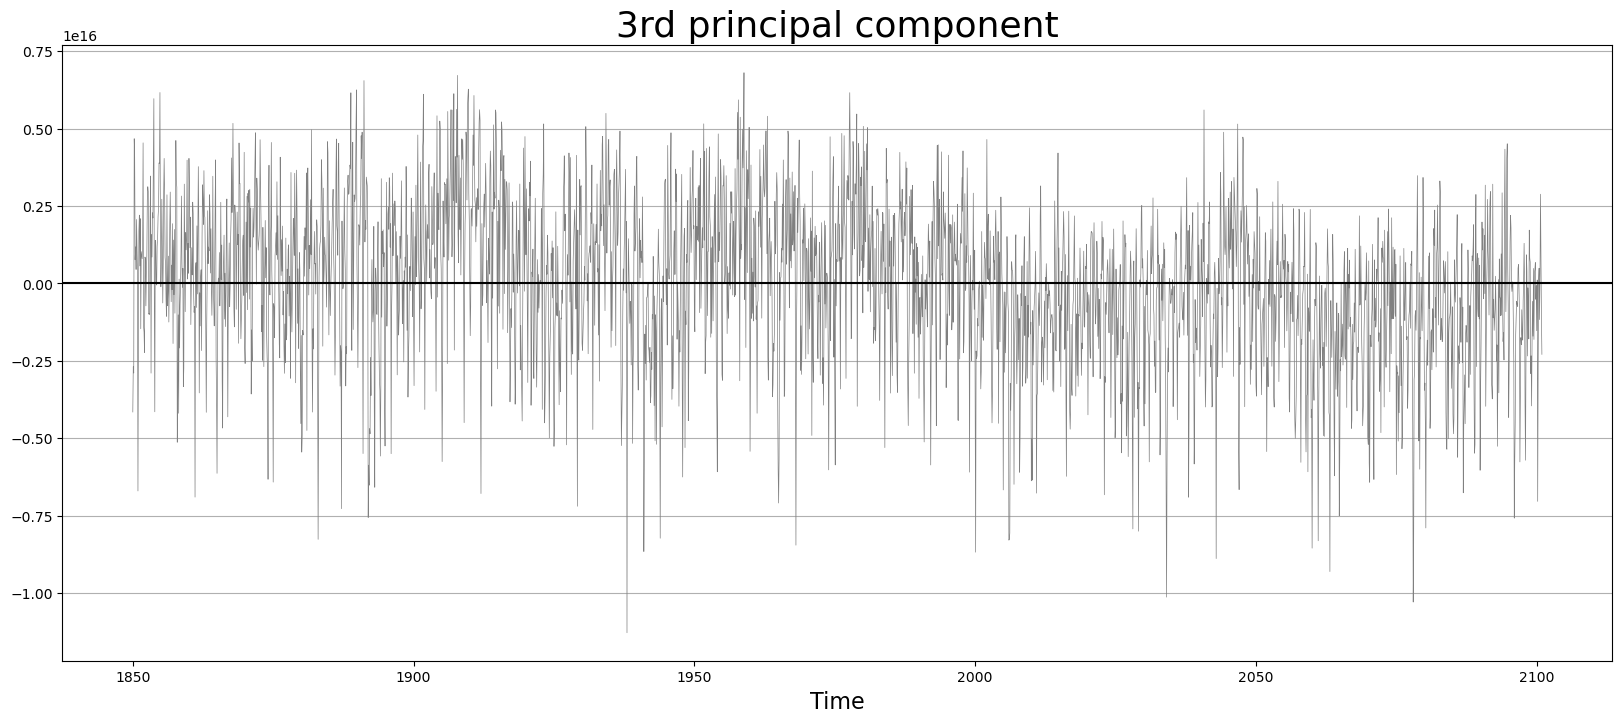

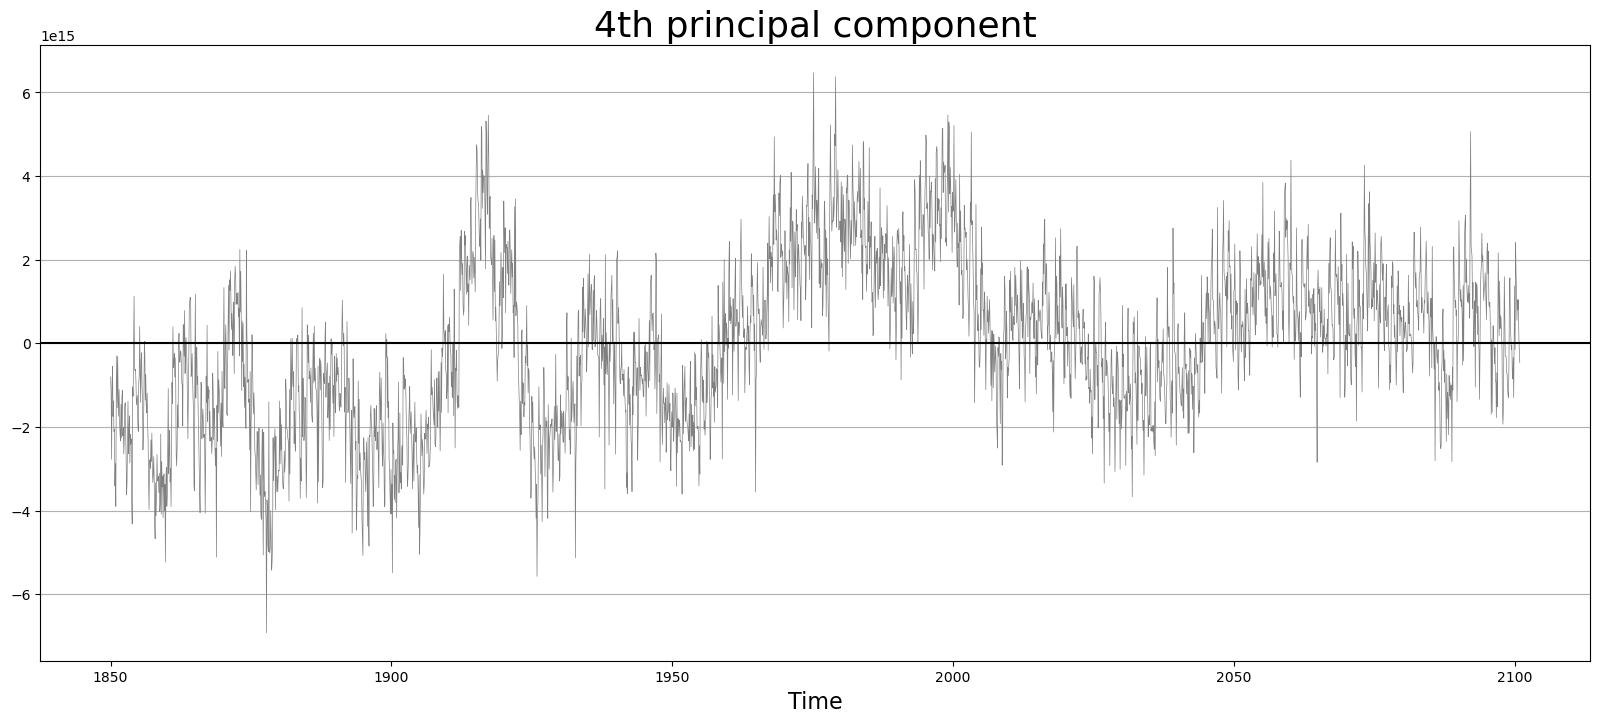

In [5]:
save_name = ['PC1.png','PC2.png','PC3.png','PC4.png']
title = ['1st principal component','2nd principal component','3rd principal component','4th principal component']

for k in range(len(save_name)):
    timeseries = pcs[:,k].values
    time = np.arange(1850,1850+(len(timeseries)/12),1/12)
    
    fig = plt.figure(figsize=(20,8))
    plt.plot(time, timeseries, linewidth= 0.5, alpha=1,color='grey')
    ax = plt.gca()
    #ax.set_ylim(-5, 5)
    ax.set_title(title[k], fontsize=16)
    ax.axhline(0, color='k')
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('', fontsize=16)
    ax.set_title(title[k], fontsize=26)
    ax.grid(axis='y')
    plt.show()
    #plt.savefig(path+save_name[k], bbox_inches='tight')

### Plot Empirical Orthogonal Functions


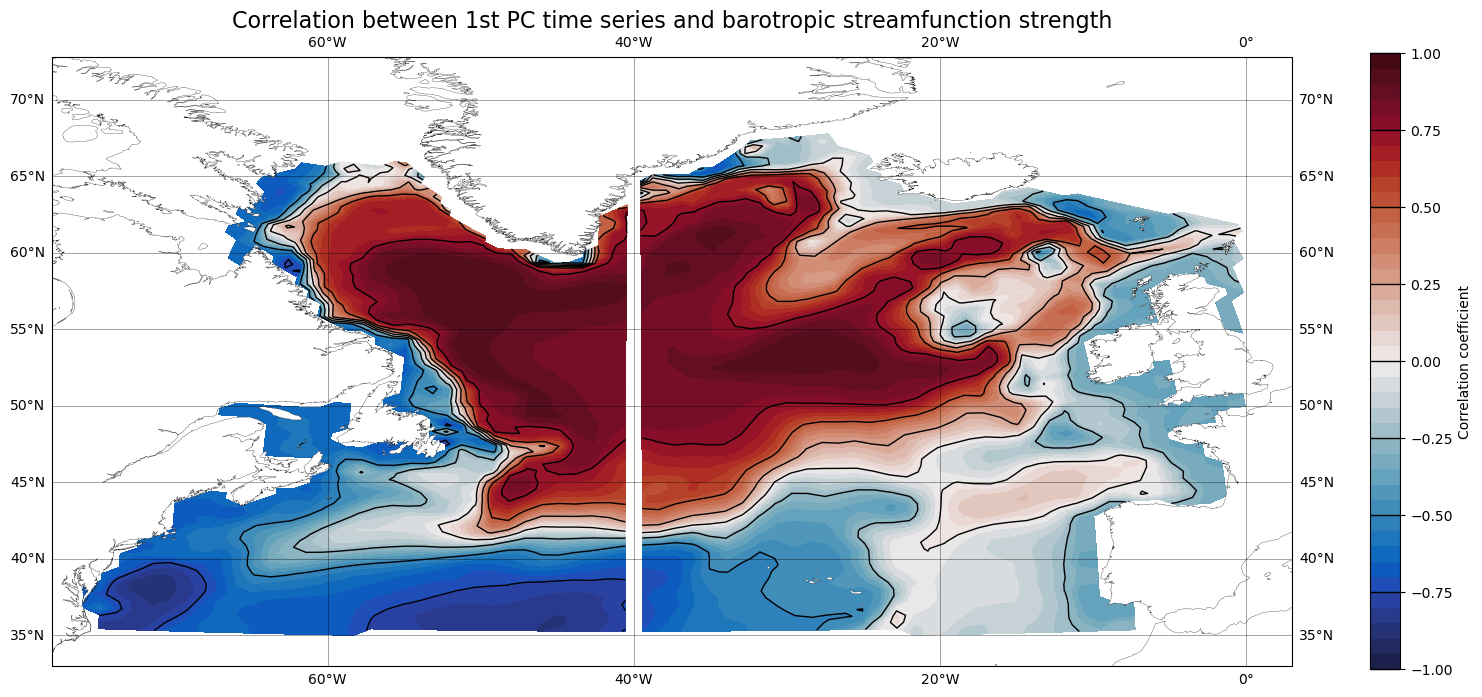

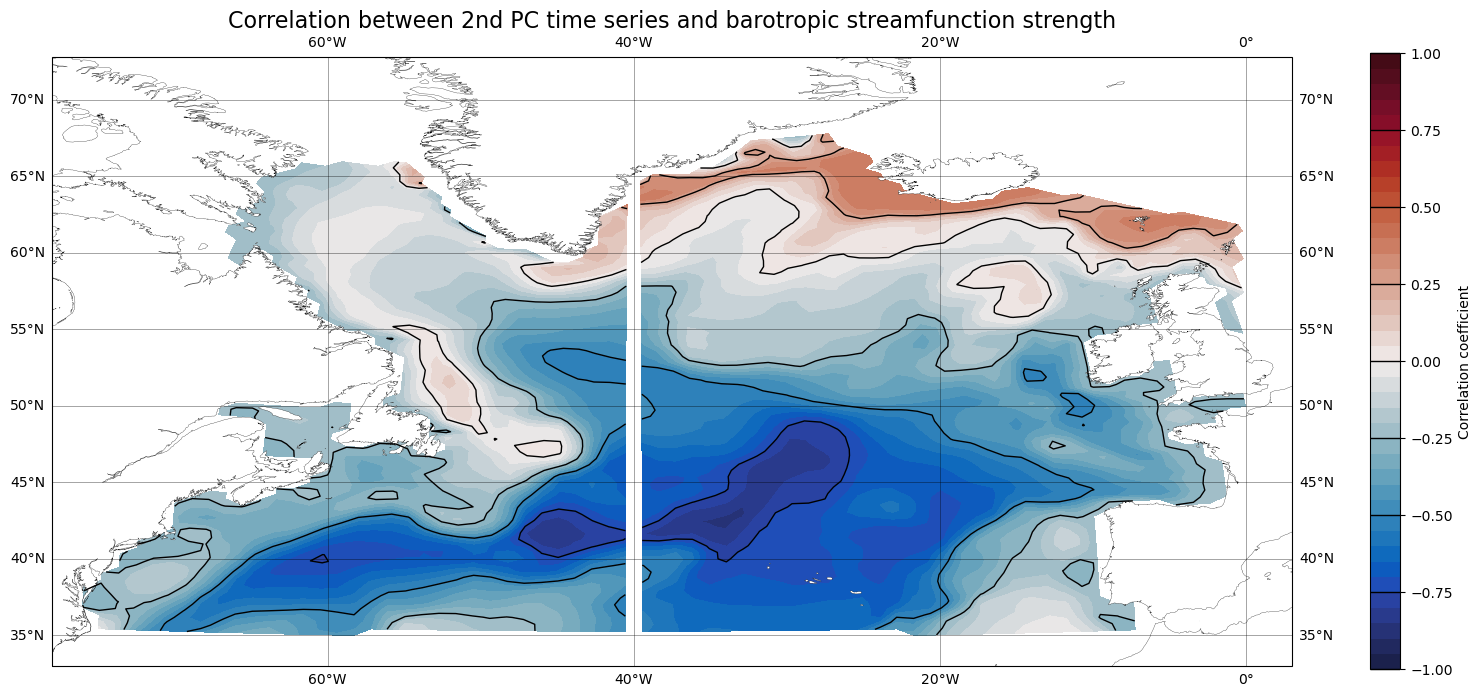

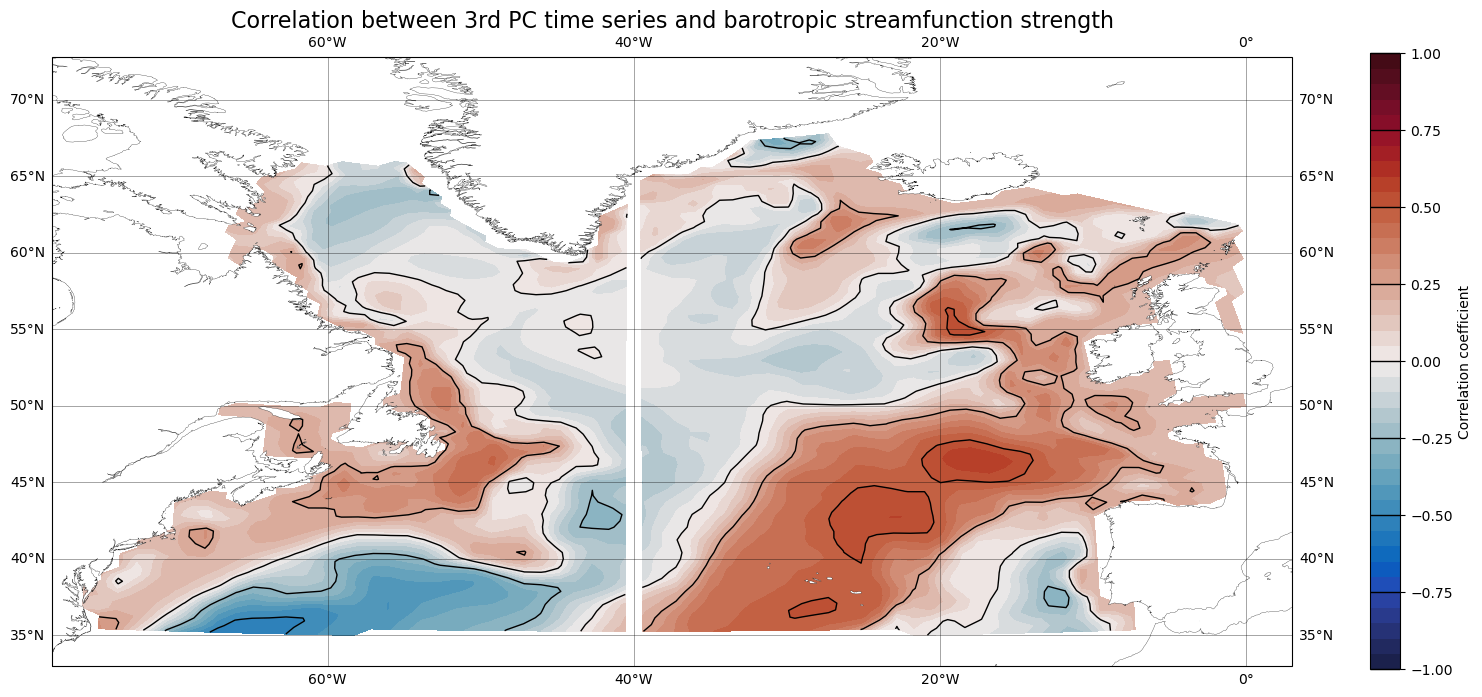

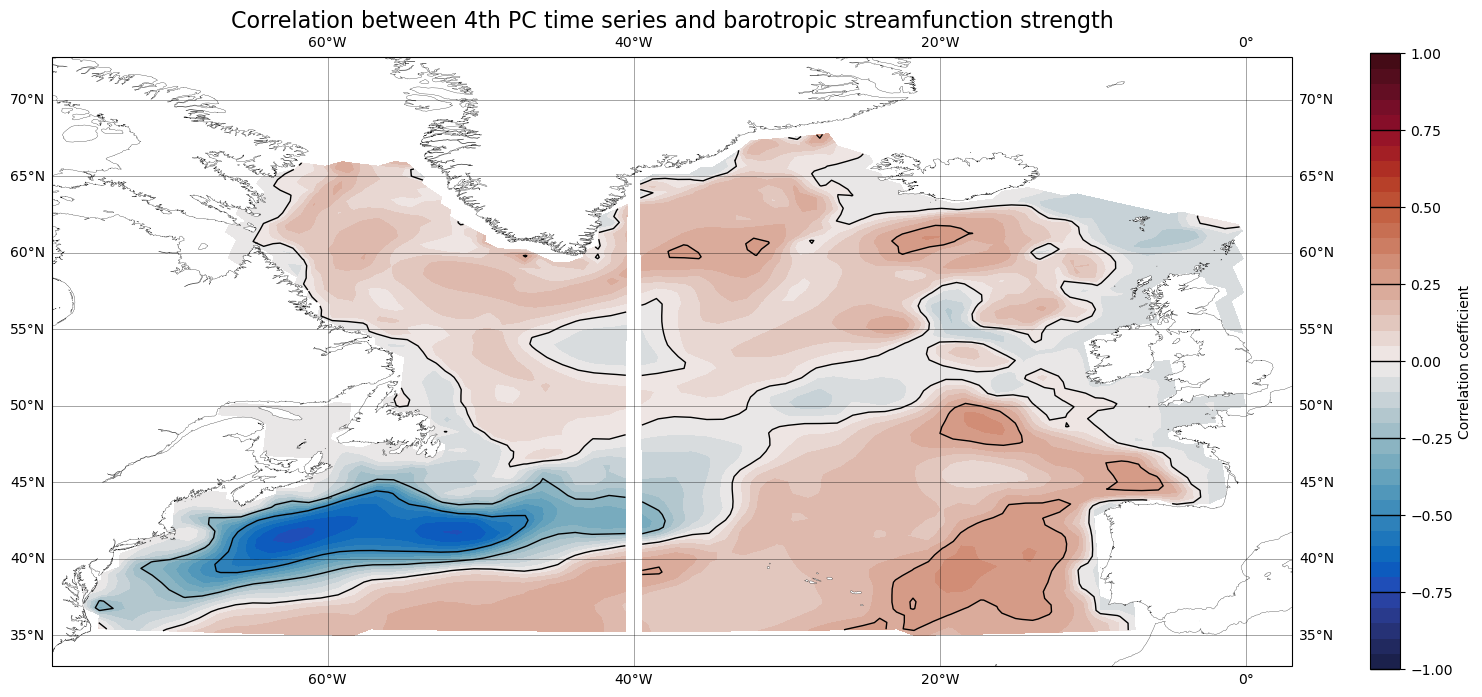

In [6]:
# set kwargs
crs = cartopy.crs.PlateCarree()
levels = np.linspace(-1, 1, 41)
cmap = cmo.balance
extent = [-78, 3, 33, 68]
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.2, edgecolor='black', facecolor='white')
title = ['Correlation between 1st PC time series and barotropic streamfunction strength',
         'Correlation between 2nd PC time series and barotropic streamfunction strength',
         'Correlation between 3rd PC time series and barotropic streamfunction strength',
         'Correlation between 4th PC time series and barotropic streamfunction strength']
save_name = ['COR1.png','COR2.png','COR3.png','COR4.png']
         
# plot
for j in range(len(save_name)):
    fig = plt.figure(figsize=(20,8))
    ax = plt.axes(projection=crs)
    land = ax.add_feature(nature_coast)
    ax.gridlines(crs=crs, linewidth=0.5, color='black', alpha=0.5, linestyle='-', draw_labels=True)
    ax.set_extent(extent)
    ax.set_title(title[j], fontsize=16)
    # plot map
    cf = ax.contourf(ds.TLONG, ds.TLAT, eof_corr[j], levels=levels, cmap = cmap, norm = norm)
    # plot contours
    cf2 = ax.contour(ds.TLONG, ds.TLAT, eof_corr[j], levels=levels[::5], colors=['k',],linewidths=1, linestyles='solid')
    # plot colorbaar
    cbar = fig.colorbar(cf, ax=ax)
    cbar.ax.set_ylabel('Correlation coefficient')
    # Add the contour line levels to the colorbar
    cbar.add_lines(cf2)
    plt.show()
    #plt.savefig(path+save_name[j], bbox_inches='tight')

# EOF index

I need to make a choice on the definition of the sub polar gyre index:
1. Does the EOF decide on the region where I take the minimum of BSF?
2. Or should I use the first of the PCS as a measure for the sub polar gyre strength? Here I need tomake sure that reasonable values come out. Either scale to unit variance PCs or EOF or don’t 
3. Or should I take the minimum of the reconstructed field of the first EOF and PC?

Is there a difference between 2nd and 3rd?

In [7]:
# Calculate index by leting 1st eof define the area and then calculating minimum
# create map of bsf where correlation between pc and original data is < 0.75
first_eof_ds = ds.where(eof_corr[0]> 0.75)
# calculate minimum of BSF in this area
bsf_min = first_eof_ds.BSF.min(('nlon','nlat')).values
# create time series
time = np.arange(1850,1850+(len(bsf_min)/12),1/12)

In [8]:
try:
    from collections.abc import Callable  # noqa
except ImportError:
    from collections import Callable  # noqa

In [9]:
# Calculate index by reconstructing field and taking minimum
# reconstuction of data field based on 1st EOF
reconstruction = solver.reconstructedField(1)
bsf_min_3 = reconstruction.min(('nlon','nlat')).values

AttributeError: module 'collections' has no attribute 'Iterable'

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot first time series on the first y-axis
p1, = ax1.plot(time, bsf_min, label='min bsf found via first eof corr > 0.75',linewidth= 1, alpha=0.5, color='maroon')
p2, = ax1.plot(time, bsf_min_3, label='min bsf of reconstructed eof1', linewidth= 0.5, alpha=0.5, color='royalblue')
ax1.set_xlabel('Time [years]', fontsize=15)
ax1.set_ylabel('Circulation Strength [Sverdrup]', fontsize=15)

# Create a second y-axis object
ax2 = ax1.twinx()

# Plot second time series on the second y-axis
p3, = ax2.plot(time, pcs[:,0].values, label='1st principal component', linewidth= 0.5, alpha=0.8, color='black')
ax2.set_ylabel('1st PC timeseries units', fontsize=15)

# Combine legend entries from all three time series
handles = [p1, p2, p3]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels,  fontsize=15)

# Show the plot
plt.show()